In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.2')
pyro.set_rng_seed(1)

In [2]:
# license: Copyright (c) 2014, the Open Data Science Initiative
# license: https://www.elsevier.com/legal/elsevier-website-terms-and-conditions
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [3]:
df

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64 TE,-0.981846,0.652971,-0.376022,-1.414495,0.372440,-0.978892,-0.636869,-0.856056,-0.767485,-1.365015,...,1.112031,0.618734,-0.344299,0.952105,-0.272503,-1.453339,0.299896,0.844418,1.251070,-1.276398
64 TE,-1.298196,0.980800,-0.767402,-1.408511,0.551521,-0.644643,0.926355,-0.478230,-0.739008,-1.428797,...,0.385848,1.068621,1.203923,1.057349,-0.064275,-1.068977,0.966150,0.988691,1.394258,-1.154409
64 TE,-0.716994,0.787200,0.020074,1.226372,0.638402,-0.806083,1.003183,-1.200070,-0.506173,-1.331172,...,0.185657,0.686556,0.175714,1.108408,-0.262818,-0.877706,0.270610,1.058685,1.463726,-1.170975
64 TE,-1.003917,1.522880,-0.289572,-1.532177,0.246551,-0.603714,0.656671,0.877241,-0.940018,-1.345490,...,0.911840,1.226873,1.071556,0.878122,-0.038448,-1.324004,0.731863,0.742998,1.150413,-1.160433


In [4]:
data = torch.tensor(df.values, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

In [6]:
y.shape

torch.Size([48, 437])

In [7]:
capture_time = y.new_tensor([int(cell_name.split(" ")[0]) for cell_name in df.index.values])
# we scale the time into the interval [0, 1]
time = capture_time.log2() / 6

# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)  # shape: 437 x 2
X_prior_mean[:, 0] = time

In [15]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

In [16]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

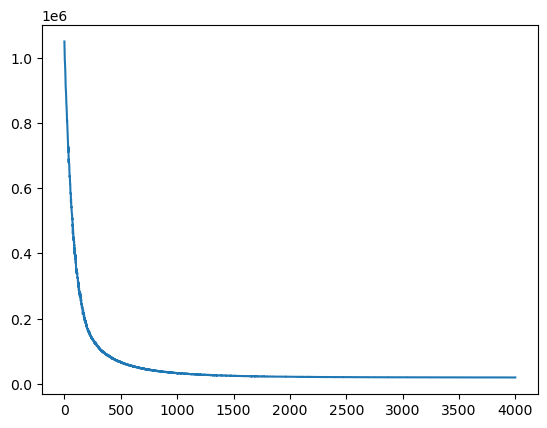

In [17]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [18]:
gplvm.mode = "guide"
X = gplvm.X 

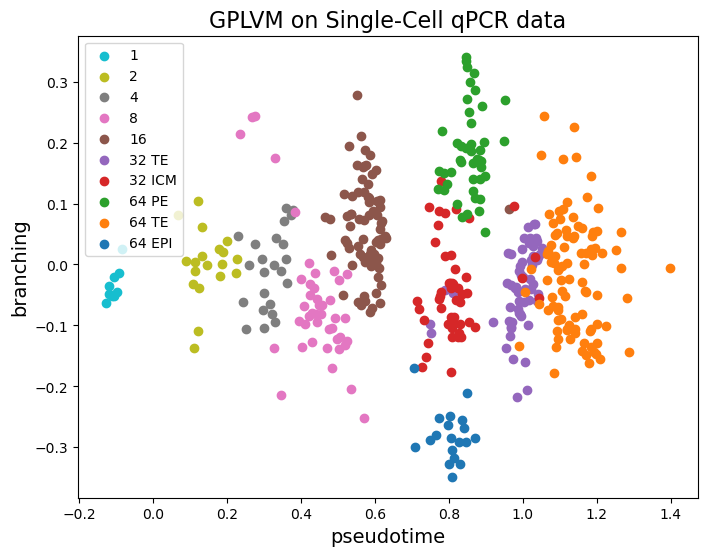

In [27]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

X = gplvm.X_loc.detach().numpy()
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR data", fontsize=16)
plt.show()